# MIRI LRS Slit Spectroscopy: Spectral Extraction using the JWST Pipeline

July 2023

**Use case:** Spectral extraction of slit spectra with the JWST calibration pipeline.<br>
**Data:** Publicly available science data<br>
**Tools:** jwst, matplotlib, astropy.<br>
**Cross-intrument:** NIRSpec, MIRI.<br>
**Documentation:** This notebook is part of a STScI's larger [post-pipeline Data Analysis Tools Ecosystem](https://jwst-docs.stsci.edu/jwst-post-pipeline-data-analysis) and can be [downloaded](https://github.com/spacetelescope/dat_pyinthesky/tree/main/jdat_notebooks/MRS_Mstar_analysis) directly from the [JDAT Notebook Github directory](https://github.com/spacetelescope/jdat_notebooks).<br>


### Introduction: Spectral extraction in the JWST calibration pipeline

The JWST calibration pipeline performs spectrac extraction for all spectroscopic data using basic default assumptions that are tuned to produce accurately calibrated spectra for the majority of science cases. This default method is a simple fixed-width boxcar extraction, where the spectrum is summed over a number of pixels along the cross-dispersion axis, over the valid wavelength range. An aperture correction is applied at each pixel along the spectrum to account for flux lost from the finite-width aperture. 

The ``extract_1d`` step uses the following inputs for its algorithm:
- the spectral extraction reference file: this is a json-formatted file, available as a reference file from the [JWST CRDS system](https://jwst-crds.stsci.edu)
- the bounding box: the ``assign_wcs`` step attaches a bounding box definition to the data, which defines the region over which a valid calibration is available. We will demonstrate below how to visualize this region. 

However the ``extract_1d`` step has the capability to perform more complex spectral extractions, requiring some manual editing of parameters and re-running of the pipeline step. 


### Aims

This notebook will demonstrate how to re-run the spectral extraction step with different settings to illustrate the capabilities of the JWST calibration pipeline. 


### Assumptions

We will demonstrate the spectral extraction methods on resampled, calibrated spectral images. The basic demo and two examples run on Level 3 data, in which the nod exposures have been combined into a single spectral image. Two examples will use the Level 2b data - one of the nodded exposures. 


### Test data

The data used in this notebook is an observation of the Type Ia supernova SN2021aefx, observed by Jha et al in PID 2072 (Obs 1). These data were taken with zero exclusive access period, and published in [Kwok et al 2023](https://ui.adsabs.harvard.edu/abs/2023ApJ...944L...3K/abstract). You can retrieve the data from [this Box folder](https://stsci.box.com/s/i2xi18jziu1iawpkom0z2r94kvf9n9kb), and we recommend you place the files in the ``data/`` folder of this repository, or change the directory settings in the notebook prior to running. 

You can of course use your own data instead of the demo data. 


### JWST pipeline version and CRDS context

This notebook was written using the calibration pipeline version 1.10.2. We set the CRDS context explicitly to 1089 to match the current latest version in MAST. If you use different pipeline versions or CRDS context, please read the relevant release notes ([here for pipeline](https://github.com/spacetelescope/jwst), [here for CRDS](https://jwst-crds.stsci.edu)) for possibly relevant changes.

### Contents

1. [The Level 3 data products](#l3data)
2. [The spectral extraction reference file](#x1dref)
3. [Example 1: Changing the aperture width](#ex1)
4. [Example 2: Changing the aperture location](#ex2)
5. [Example 3: Extraction with background subtraction](#ex3)
6. [Example 4: Tapered column extraction](#ex4)



## Import Packages

- `astropy.io` fits for accessing FITS files
- `os` for managing system paths
- `matplotlib` for plotting data
- `urllib` for downloading data
- `tarfile` for unpacking data
- `numpy` for basic array manipulation
- `jwst` for running JWST pipeline and handling data products
- `json` for working with json files
- `crds` for working with JWST reference files

In [1]:
# Set CRDS variables first
import os

os.environ['CRDS_CONTEXT'] = 'jwst_1089.pmap'
os.environ['CRDS_PATH'] = os.environ['HOME']+'/crds_cache'
os.environ['CRDS_SERVER_URL'] = 'https://jwst-crds.stsci.edu'
print(f'CRDS cache location: {os.environ["CRDS_PATH"]}')

CRDS cache location: /home/runner/crds_cache


In [2]:
%matplotlib inline
import urllib.request
import tarfile

import numpy as np
import matplotlib.pyplot as plt

import astropy.io.fits as fits
import astropy.units as u
from astropy.modeling import models, fitting

import jwst
from jwst import datamodels
from jwst.extract_1d import Extract1dStep

from matplotlib.patches import Rectangle

import json
import crds

print(f'Using JWST calibration pipeline version {jwst.__version__}')

Using JWST calibration pipeline version 1.18.0


In [3]:
data_tar_url = 'https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/MIRI_LRS_notebook/data.tar.gz'

# Download and unpack data if needed
if not os.path.exists("data.tar.gz"):
    print("Downloading Data")
    urllib.request.urlretrieve(data_tar_url, 'data.tar.gz')
if not os.path.exists("data/"):
    print("Unpacking Data")
    with tarfile.open('./data.tar.gz', "r:gz") as tar:
        tar.extractall(filter='data')

Unpacking Data


## 1. The Level 3 Data Products <a id='l3data'></a>


Let's start by plotting the main default Level 3 output products:
* the ``s2d`` file: this is the 2D image built from the co-added resampled individual nod exposures. 
* the ``x1d`` file: this is the 1-D extracted spectrum, extracted from the Level 3 ``s2d`` file. 

The ``s2d`` image shows a bright central trace, flanked by two negative traces. These result from the combination of the nod exposures, each of which also contains a positive and negative trace due to being mutually subtracted for background subtraction. 

We restrict the short-wavelength end of the x-axis to 5 micron, as our calibration is very poor below this wavelength. The Level 3 spectrum is extracted from the resampled, dither-combined, calibrated exposure. 

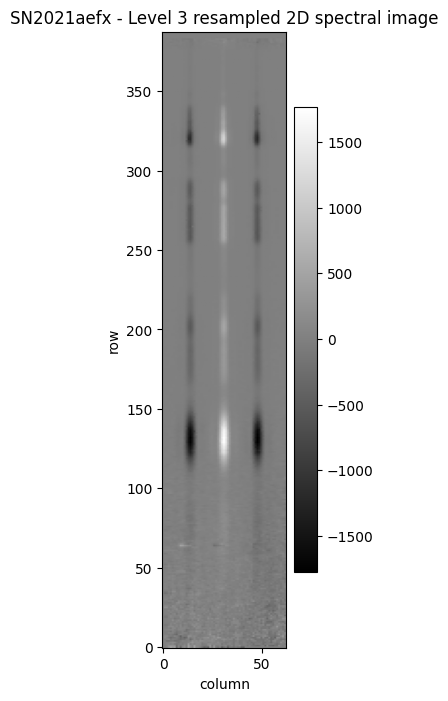

In [4]:
l3_s2d_file = 'data/jw02072-o001_t010_miri_p750l_s2d_1089.fits'
l3_s2d = datamodels.open(l3_s2d_file)
fig, ax = plt.subplots(figsize=[2, 8])
im2d = ax.imshow(l3_s2d.data, origin='lower', aspect='auto', cmap='gist_gray')
ax.set_xlabel('column')
ax.set_ylabel('row')
ax.set_title('SN2021aefx - Level 3 resampled 2D spectral image')
fig.colorbar(im2d)
fig.show()

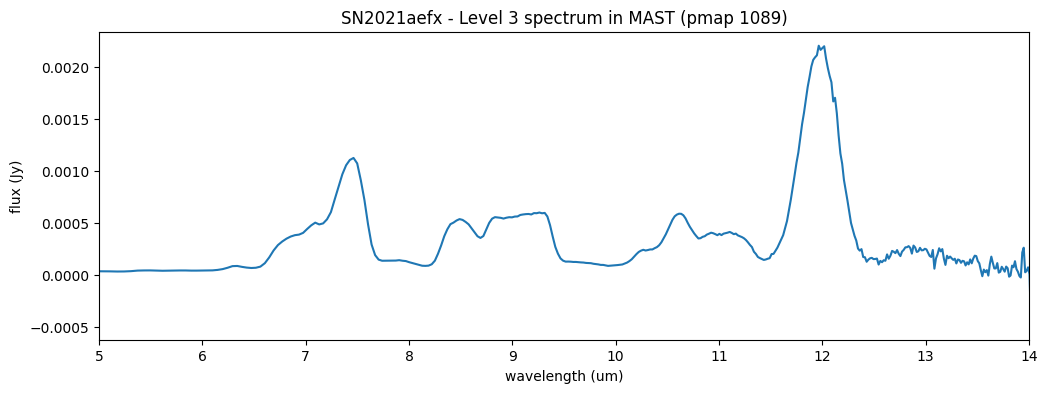

In [5]:
l3_file = 'data/jw02072-o001_t010_miri_p750l_x1d_1089.fits'
l3_spec = datamodels.open(l3_file)

fig2, ax2 = plt.subplots(figsize=[12, 4])
ax2.plot(l3_spec.spec[0].spec_table['WAVELENGTH'], l3_spec.spec[0].spec_table['FLUX'])
ax2.set_xlabel('wavelength (um)')
ax2.set_ylabel('flux (Jy)')
ax2.set_title('SN2021aefx - Level 3 spectrum in MAST (pmap 1089)')
ax2.set_xlim(5., 14.)
fig2.show()

## The spectral extraction reference file <a id='x1dref'></a>

The reference file that tells the ``extract_1d`` algorithm what parameters to use is a text file using the `json` format that is available in [CRDS](https://jwst-crds.stsci.edu). The second reference file used in the extraction is the aperture correction; this corrects for the flux lost as a function of wavelength for the extraction aperture size used. You can use the datamodel attributes of the ``x1d`` file to check which extraction reference file was called by the algorithm. 

We show below how to examine the file programmatically to see what aperture was used to produce the default Level 3 spectrum shown above. **Note: this json file can easily be opened and edited with a simple text editor**.  

Full documentation of the ``extract_1d`` reference file is available [here](https://jwst-pipeline.readthedocs.io/en/latest/jwst/extract_1d/reference_files.html). We recommend you read this page and any links therein carefully to understand how the parameters in the file are applied to the data. 

In [6]:
print(f'Spectral extraction reference file used: {l3_spec.meta.ref_file.extract1d.name}')

Spectral extraction reference file used: crds://jwst_miri_extract1d_0005.json


In [7]:
file_path = 'data/jw02072-o001_t010_miri_p750l_x1d_1089.fits'
with fits.open(file_path) as hdul:
    header = hdul[0].header
    json_ref_default = crds.getreferences(header)['extract1d']

    with open(json_ref_default) as json_ref:
        x1dref_default = json.load(json_ref)
        print('Settings for SLIT data: {}'.format(x1dref_default['apertures'][0]))
        print('  ')
        print('Settings for SLITLESS data: {}'.format(x1dref_default['apertures'][1]))

CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_system_datalvl_0002.rmap      694 bytes  (1 / 183 files) (0 / 584.8 K bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_system_calver_0033.rmap    4.1 K bytes  (2 / 183 files) (694 / 584.8 K bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_system_0032.imap      385 bytes  (3 / 183 files) (4.8 K / 584.8 K bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nirspec_wavelengthrange_0020.rmap    1.5 K bytes  (4 / 183 files) (5.2 K / 584.8 K bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nirspec_wavecorr_0005.rmap      884 bytes  (5 / 183 files) (6.7 K / 584.8 K bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nirspec_superbias_0062.rmap   29.9 K bytes  (6 / 183 files) (7.6 K / 584.8 K bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nirspec_sflat_0023.rmap   20.6 K bytes  (7 / 183 files) (37.5 K / 584.8 K bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nirspec_saturation_0018.rmap    2.0 K bytes  (8 / 183 files) (58.1 K / 584.8 K bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nirspec_refpix_0015.rmap    1.6 K bytes  (9 / 183 files) (60.1 K / 584.8 K bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nirspec_readnoise_0025.rmap    2.6 K bytes  (10 / 183 files) (61.7 K / 584.8 K bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nirspec_photom_0013.rmap      958 bytes  (11 / 183 files) (64.2 K / 584.8 K bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nirspec_pathloss_0005.rmap      983 bytes  (12 / 183 files) (65.2 K / 584.8 K bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nirspec_pars-whitelightstep_0001.rmap      777 bytes  (13 / 183 files) (66.2 K / 584.8 K bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nirspec_pars-spec2pipeline_0013.rmap    2.1 K bytes  (14 / 183 files) (67.0 K / 584.8 K bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nirspec_pars-jumpstep_0004.rmap      810 bytes  (15 / 183 files) (69.1 K / 584.8 K bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nirspec_pars-image2pipeline_0008.rmap    1.0 K bytes  (16 / 183 files) (69.9 K / 584.8 K bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nirspec_pars-detector1pipeline_0003.rmap    1.1 K bytes  (17 / 183 files) (70.9 K / 584.8 K bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nirspec_pars-darkpipeline_0003.rmap      872 bytes  (18 / 183 files) (71.9 K / 584.8 K bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nirspec_ote_0028.rmap    1.2 K bytes  (19 / 183 files) (72.8 K / 584.8 K bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nirspec_msaoper_0009.rmap    1.2 K bytes  (20 / 183 files) (74.0 K / 584.8 K bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nirspec_msa_0025.rmap    1.2 K bytes  (21 / 183 files) (75.2 K / 584.8 K bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nirspec_mask_0031.rmap    1.9 K bytes  (22 / 183 files) (76.4 K / 584.8 K bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nirspec_linearity_0017.rmap    1.6 K bytes  (23 / 183 files) (78.4 K / 584.8 K bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nirspec_ipc_0006.rmap      876 bytes  (24 / 183 files) (79.9 K / 584.8 K bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nirspec_ifuslicer_0015.rmap    1.5 K bytes  (25 / 183 files) (80.8 K / 584.8 K bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nirspec_ifupost_0017.rmap    1.4 K bytes  (26 / 183 files) (82.3 K / 584.8 K bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nirspec_ifufore_0015.rmap    1.4 K bytes  (27 / 183 files) (83.7 K / 584.8 K bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nirspec_gain_0023.rmap    1.8 K bytes  (28 / 183 files) (85.1 K / 584.8 K bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nirspec_fpa_0026.rmap    1.2 K bytes  (29 / 183 files) (86.9 K / 584.8 K bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nirspec_fore_0024.rmap    4.5 K bytes  (30 / 183 files) (88.1 K / 584.8 K bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nirspec_flat_0015.rmap    3.8 K bytes  (31 / 183 files) (92.6 K / 584.8 K bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nirspec_fflat_0017.rmap    7.2 K bytes  (32 / 183 files) (96.4 K / 584.8 K bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nirspec_extract1d_0016.rmap    2.3 K bytes  (33 / 183 files) (103.6 K / 584.8 K bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nirspec_disperser_0026.rmap    5.1 K bytes  (34 / 183 files) (105.9 K / 584.8 K bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nirspec_dflat_0007.rmap    1.1 K bytes  (35 / 183 files) (111.0 K / 584.8 K bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nirspec_dark_0055.rmap   28.5 K bytes  (36 / 183 files) (112.2 K / 584.8 K bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nirspec_cubepar_0014.rmap      966 bytes  (37 / 183 files) (140.6 K / 584.8 K bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nirspec_collimator_0024.rmap    1.3 K bytes  (38 / 183 files) (141.6 K / 584.8 K bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nirspec_camera_0024.rmap    1.2 K bytes  (39 / 183 files) (142.9 K / 584.8 K bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nirspec_barshadow_0004.rmap      928 bytes  (40 / 183 files) (144.1 K / 584.8 K bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nirspec_area_0018.rmap    6.3 K bytes  (41 / 183 files) (145.0 K / 584.8 K bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nirspec_apcorr_0009.rmap    5.6 K bytes  (42 / 183 files) (151.3 K / 584.8 K bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nirspec_0326.imap    5.2 K bytes  (43 / 183 files) (156.8 K / 584.8 K bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_niriss_wfssbkg_0007.rmap    3.1 K bytes  (44 / 183 files) (162.0 K / 584.8 K bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_niriss_wavemap_0008.rmap    2.2 K bytes  (45 / 183 files) (165.1 K / 584.8 K bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_niriss_wavelengthrange_0006.rmap      862 bytes  (46 / 183 files) (167.4 K / 584.8 K bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_niriss_trappars_0004.rmap      753 bytes  (47 / 183 files) (168.2 K / 584.8 K bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_niriss_trapdensity_0004.rmap      774 bytes  (48 / 183 files) (169.0 K / 584.8 K bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_niriss_throughput_0004.rmap      979 bytes  (49 / 183 files) (169.8 K / 584.8 K bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_niriss_superbias_0025.rmap    7.2 K bytes  (50 / 183 files) (170.7 K / 584.8 K bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_niriss_specwcs_0010.rmap    3.1 K bytes  (51 / 183 files) (178.0 K / 584.8 K bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_niriss_spectrace_0008.rmap    2.3 K bytes  (52 / 183 files) (181.1 K / 584.8 K bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_niriss_specprofile_0008.rmap    2.4 K bytes  (53 / 183 files) (183.4 K / 584.8 K bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_niriss_speckernel_0006.rmap    1.0 K bytes  (54 / 183 files) (185.8 K / 584.8 K bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_niriss_saturation_0014.rmap      761 bytes  (55 / 183 files) (186.8 K / 584.8 K bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_niriss_readnoise_0011.rmap      987 bytes  (56 / 183 files) (187.6 K / 584.8 K bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_niriss_photom_0031.rmap    1.2 K bytes  (57 / 183 files) (188.6 K / 584.8 K bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_niriss_persat_0006.rmap      738 bytes  (58 / 183 files) (189.8 K / 584.8 K bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_niriss_pathloss_0003.rmap      758 bytes  (59 / 183 files) (190.5 K / 584.8 K bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_niriss_pars-undersamplecorrectionstep_0001.rmap      904 bytes  (60 / 183 files) (191.3 K / 584.8 K bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_niriss_pars-tweakregstep_0005.rmap    3.1 K bytes  (61 / 183 files) (192.2 K / 584.8 K bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_niriss_pars-spec2pipeline_0008.rmap      984 bytes  (62 / 183 files) (195.3 K / 584.8 K bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_niriss_pars-sourcecatalogstep_0001.rmap      668 bytes  (63 / 183 files) (196.3 K / 584.8 K bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_niriss_pars-outlierdetectionstep_0004.rmap    2.7 K bytes  (64 / 183 files) (197.0 K / 584.8 K bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_niriss_pars-jumpstep_0006.rmap    4.5 K bytes  (65 / 183 files) (199.6 K / 584.8 K bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_niriss_pars-image2pipeline_0005.rmap    1.0 K bytes  (66 / 183 files) (204.1 K / 584.8 K bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_niriss_pars-detector1pipeline_0002.rmap    1.0 K bytes  (67 / 183 files) (205.1 K / 584.8 K bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_niriss_pars-darkpipeline_0002.rmap      868 bytes  (68 / 183 files) (206.2 K / 584.8 K bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_niriss_mask_0020.rmap      859 bytes  (69 / 183 files) (207.0 K / 584.8 K bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_niriss_linearity_0021.rmap      894 bytes  (70 / 183 files) (207.9 K / 584.8 K bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_niriss_ipc_0007.rmap      651 bytes  (71 / 183 files) (208.8 K / 584.8 K bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_niriss_gain_0011.rmap      797 bytes  (72 / 183 files) (209.4 K / 584.8 K bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_niriss_flat_0023.rmap    5.9 K bytes  (73 / 183 files) (210.2 K / 584.8 K bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_niriss_filteroffset_0007.rmap      844 bytes  (74 / 183 files) (216.1 K / 584.8 K bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_niriss_extract1d_0007.rmap      905 bytes  (75 / 183 files) (216.9 K / 584.8 K bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_niriss_drizpars_0004.rmap      519 bytes  (76 / 183 files) (217.8 K / 584.8 K bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_niriss_distortion_0023.rmap    3.4 K bytes  (77 / 183 files) (218.4 K / 584.8 K bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_niriss_dark_0031.rmap    6.8 K bytes  (78 / 183 files) (221.8 K / 584.8 K bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_niriss_area_0014.rmap    2.7 K bytes  (79 / 183 files) (228.6 K / 584.8 K bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_niriss_apcorr_0006.rmap    4.3 K bytes  (80 / 183 files) (231.3 K / 584.8 K bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_niriss_abvegaoffset_0004.rmap    1.4 K bytes  (81 / 183 files) (235.6 K / 584.8 K bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_niriss_0218.imap    5.3 K bytes  (82 / 183 files) (237.0 K / 584.8 K bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nircam_wfssbkg_0004.rmap    7.2 K bytes  (83 / 183 files) (242.2 K / 584.8 K bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nircam_wavelengthrange_0010.rmap      996 bytes  (84 / 183 files) (249.4 K / 584.8 K bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nircam_tsophot_0003.rmap      896 bytes  (85 / 183 files) (250.4 K / 584.8 K bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nircam_trappars_0003.rmap    1.6 K bytes  (86 / 183 files) (251.3 K / 584.8 K bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nircam_trapdensity_0003.rmap    1.6 K bytes  (87 / 183 files) (252.9 K / 584.8 K bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nircam_superbias_0015.rmap   12.7 K bytes  (88 / 183 files) (254.5 K / 584.8 K bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nircam_specwcs_0018.rmap    7.1 K bytes  (89 / 183 files) (267.2 K / 584.8 K bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nircam_saturation_0010.rmap    2.2 K bytes  (90 / 183 files) (274.3 K / 584.8 K bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nircam_readnoise_0022.rmap   19.9 K bytes  (91 / 183 files) (276.5 K / 584.8 K bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nircam_psfmask_0007.rmap   11.0 K bytes  (92 / 183 files) (296.4 K / 584.8 K bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nircam_photom_0017.rmap    3.4 K bytes  (93 / 183 files) (307.4 K / 584.8 K bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nircam_persat_0005.rmap    1.6 K bytes  (94 / 183 files) (310.8 K / 584.8 K bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nircam_pars-whitelightstep_0003.rmap    1.5 K bytes  (95 / 183 files) (312.3 K / 584.8 K bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nircam_pars-tweakregstep_0003.rmap    4.5 K bytes  (96 / 183 files) (313.8 K / 584.8 K bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nircam_pars-spec2pipeline_0008.rmap      984 bytes  (97 / 183 files) (318.3 K / 584.8 K bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nircam_pars-sourcecatalogstep_0001.rmap      668 bytes  (98 / 183 files) (319.2 K / 584.8 K bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nircam_pars-outlierdetectionstep_0003.rmap      940 bytes  (99 / 183 files) (319.9 K / 584.8 K bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nircam_pars-jumpstep_0004.rmap      806 bytes  (100 / 183 files) (320.8 K / 584.8 K bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nircam_pars-image2pipeline_0003.rmap    1.0 K bytes  (101 / 183 files) (321.6 K / 584.8 K bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nircam_pars-detector1pipeline_0002.rmap    1.0 K bytes  (102 / 183 files) (322.7 K / 584.8 K bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nircam_pars-darkpipeline_0002.rmap      868 bytes  (103 / 183 files) (323.7 K / 584.8 K bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nircam_mask_0010.rmap    2.9 K bytes  (104 / 183 files) (324.6 K / 584.8 K bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nircam_linearity_0011.rmap    2.4 K bytes  (105 / 183 files) (327.5 K / 584.8 K bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nircam_ipc_0003.rmap    2.0 K bytes  (106 / 183 files) (329.9 K / 584.8 K bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nircam_gain_0016.rmap    2.1 K bytes  (107 / 183 files) (331.8 K / 584.8 K bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nircam_flat_0024.rmap   51.6 K bytes  (108 / 183 files) (334.0 K / 584.8 K bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nircam_filteroffset_0004.rmap    1.4 K bytes  (109 / 183 files) (385.6 K / 584.8 K bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nircam_extract1d_0004.rmap      842 bytes  (110 / 183 files) (387.0 K / 584.8 K bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nircam_drizpars_0001.rmap      519 bytes  (111 / 183 files) (387.8 K / 584.8 K bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nircam_distortion_0031.rmap   23.7 K bytes  (112 / 183 files) (388.3 K / 584.8 K bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nircam_dark_0043.rmap   23.6 K bytes  (113 / 183 files) (412.0 K / 584.8 K bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nircam_area_0007.rmap    4.6 K bytes  (114 / 183 files) (435.7 K / 584.8 K bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nircam_apcorr_0008.rmap    4.3 K bytes  (115 / 183 files) (440.3 K / 584.8 K bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nircam_abvegaoffset_0002.rmap    1.3 K bytes  (116 / 183 files) (444.5 K / 584.8 K bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nircam_0258.imap    5.1 K bytes  (117 / 183 files) (445.8 K / 584.8 K bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_miri_wavelengthrange_0027.rmap      929 bytes  (118 / 183 files) (450.9 K / 584.8 K bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_miri_tsophot_0004.rmap      882 bytes  (119 / 183 files) (451.9 K / 584.8 K bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_miri_straymask_0009.rmap      987 bytes  (120 / 183 files) (452.7 K / 584.8 K bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_miri_specwcs_0035.rmap    5.8 K bytes  (121 / 183 files) (453.7 K / 584.8 K bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_miri_saturation_0015.rmap    1.2 K bytes  (122 / 183 files) (459.5 K / 584.8 K bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_miri_rscd_0008.rmap    1.0 K bytes  (123 / 183 files) (460.7 K / 584.8 K bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_miri_resol_0006.rmap      790 bytes  (124 / 183 files) (461.7 K / 584.8 K bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_miri_reset_0026.rmap    3.9 K bytes  (125 / 183 files) (462.5 K / 584.8 K bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_miri_regions_0033.rmap    5.2 K bytes  (126 / 183 files) (466.4 K / 584.8 K bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_miri_readnoise_0023.rmap    1.6 K bytes  (127 / 183 files) (471.6 K / 584.8 K bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_miri_psfmask_0008.rmap    1.6 K bytes  (128 / 183 files) (473.2 K / 584.8 K bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_miri_photom_0038.rmap    3.9 K bytes  (129 / 183 files) (474.8 K / 584.8 K bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_miri_pathloss_0004.rmap      802 bytes  (130 / 183 files) (478.7 K / 584.8 K bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_miri_pars-whitelightstep_0003.rmap      912 bytes  (131 / 183 files) (479.5 K / 584.8 K bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_miri_pars-tweakregstep_0003.rmap    1.8 K bytes  (132 / 183 files) (480.4 K / 584.8 K bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_miri_pars-spec3pipeline_0004.rmap      816 bytes  (133 / 183 files) (482.2 K / 584.8 K bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_miri_pars-spec2pipeline_0007.rmap    1.1 K bytes  (134 / 183 files) (483.0 K / 584.8 K bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_miri_pars-sourcecatalogstep_0003.rmap    1.9 K bytes  (135 / 183 files) (484.2 K / 584.8 K bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_miri_pars-outlierdetectionstep_0012.rmap    3.4 K bytes  (136 / 183 files) (486.1 K / 584.8 K bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_miri_pars-jumpstep_0006.rmap      864 bytes  (137 / 183 files) (489.4 K / 584.8 K bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_miri_pars-image2pipeline_0006.rmap      979 bytes  (138 / 183 files) (490.3 K / 584.8 K bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_miri_pars-detector1pipeline_0004.rmap    1.1 K bytes  (139 / 183 files) (491.3 K / 584.8 K bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_miri_pars-darkpipeline_0002.rmap      860 bytes  (140 / 183 files) (492.4 K / 584.8 K bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_miri_mrsxartcorr_0002.rmap    2.2 K bytes  (141 / 183 files) (493.2 K / 584.8 K bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_miri_mrsptcorr_0002.rmap    1.9 K bytes  (142 / 183 files) (495.4 K / 584.8 K bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_miri_mask_0020.rmap    1.1 K bytes  (143 / 183 files) (497.3 K / 584.8 K bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_miri_linearity_0017.rmap    2.7 K bytes  (144 / 183 files) (498.4 K / 584.8 K bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_miri_gain_0007.rmap      893 bytes  (145 / 183 files) (501.1 K / 584.8 K bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_miri_fringefreq_0003.rmap    1.4 K bytes  (146 / 183 files) (502.0 K / 584.8 K bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_miri_fringe_0018.rmap    3.7 K bytes  (147 / 183 files) (503.4 K / 584.8 K bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_miri_flat_0061.rmap   15.1 K bytes  (148 / 183 files) (507.2 K / 584.8 K bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_miri_filteroffset_0025.rmap    2.5 K bytes  (149 / 183 files) (522.3 K / 584.8 K bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_miri_extract1d_0018.rmap    1.4 K bytes  (150 / 183 files) (524.8 K / 584.8 K bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_miri_drizpars_0002.rmap      511 bytes  (151 / 183 files) (526.1 K / 584.8 K bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_miri_distortion_0039.rmap    4.9 K bytes  (152 / 183 files) (526.6 K / 584.8 K bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_miri_dark_0034.rmap    4.4 K bytes  (153 / 183 files) (531.5 K / 584.8 K bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_miri_cubepar_0014.rmap      800 bytes  (154 / 183 files) (535.9 K / 584.8 K bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_miri_area_0013.rmap      806 bytes  (155 / 183 files) (536.7 K / 584.8 K bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_miri_apcorr_0009.rmap    4.3 K bytes  (156 / 183 files) (537.5 K / 584.8 K bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_miri_abvegaoffset_0002.rmap    1.3 K bytes  (157 / 183 files) (541.8 K / 584.8 K bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_miri_0341.imap    5.2 K bytes  (158 / 183 files) (543.1 K / 584.8 K bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_fgs_trappars_0004.rmap      903 bytes  (159 / 183 files) (548.3 K / 584.8 K bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_fgs_trapdensity_0006.rmap      930 bytes  (160 / 183 files) (549.2 K / 584.8 K bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_fgs_superbias_0017.rmap    3.8 K bytes  (161 / 183 files) (550.1 K / 584.8 K bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_fgs_saturation_0009.rmap      779 bytes  (162 / 183 files) (553.9 K / 584.8 K bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_fgs_readnoise_0011.rmap    1.3 K bytes  (163 / 183 files) (554.7 K / 584.8 K bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_fgs_photom_0014.rmap    1.1 K bytes  (164 / 183 files) (556.0 K / 584.8 K bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_fgs_persat_0006.rmap      884 bytes  (165 / 183 files) (557.1 K / 584.8 K bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_fgs_pars-tweakregstep_0002.rmap      850 bytes  (166 / 183 files) (558.0 K / 584.8 K bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_fgs_pars-sourcecatalogstep_0001.rmap      636 bytes  (167 / 183 files) (558.8 K / 584.8 K bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_fgs_pars-outlierdetectionstep_0001.rmap      654 bytes  (168 / 183 files) (559.5 K / 584.8 K bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_fgs_pars-image2pipeline_0005.rmap      974 bytes  (169 / 183 files) (560.1 K / 584.8 K bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_fgs_pars-detector1pipeline_0002.rmap    1.0 K bytes  (170 / 183 files) (561.1 K / 584.8 K bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_fgs_pars-darkpipeline_0002.rmap      856 bytes  (171 / 183 files) (562.1 K / 584.8 K bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_fgs_mask_0023.rmap    1.1 K bytes  (172 / 183 files) (563.0 K / 584.8 K bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_fgs_linearity_0015.rmap      925 bytes  (173 / 183 files) (564.0 K / 584.8 K bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_fgs_ipc_0003.rmap      614 bytes  (174 / 183 files) (565.0 K / 584.8 K bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_fgs_gain_0010.rmap      890 bytes  (175 / 183 files) (565.6 K / 584.8 K bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_fgs_flat_0009.rmap    1.1 K bytes  (176 / 183 files) (566.5 K / 584.8 K bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_fgs_distortion_0009.rmap    1.2 K bytes  (177 / 183 files) (567.6 K / 584.8 K bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_fgs_dark_0017.rmap    4.3 K bytes  (178 / 183 files) (568.8 K / 584.8 K bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_fgs_area_0010.rmap    1.2 K bytes  (179 / 183 files) (573.1 K / 584.8 K bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_fgs_apcorr_0004.rmap    4.0 K bytes  (180 / 183 files) (574.3 K / 584.8 K bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_fgs_abvegaoffset_0002.rmap    1.3 K bytes  (181 / 183 files) (578.2 K / 584.8 K bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_fgs_0109.imap    4.7 K bytes  (182 / 183 files) (579.5 K / 584.8 K bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_1089.pmap         580 bytes  (183 / 183 files) (584.2 K / 584.8 K bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/references/jwst/miri/jwst_miri_mask_0036.fits    4.3 M bytes  (1 / 15 files) (0 / 6.2 G bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/references/jwst/miri/jwst_miri_pathloss_0001.fits    3.1 M bytes  (2 / 15 files) (4.3 M / 6.2 G bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/references/jwst/miri/jwst_miri_linearity_0032.fits   25.4 M bytes  (3 / 15 files) (7.4 M / 6.2 G bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/references/jwst/miri/jwst_miri_apcorr_0007.fits  262.1 K bytes  (4 / 15 files) (32.8 M / 6.2 G bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/references/jwst/miri/jwst_miri_gain_0008.fits    4.2 M bytes  (5 / 15 files) (33.0 M / 6.2 G bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/references/jwst/miri/jwst_miri_dark_0094.fits    6.1 G bytes  (6 / 15 files) (37.3 M / 6.2 G bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/references/jwst/miri/jwst_miri_specwcs_0005.fits   46.1 K bytes  (7 / 15 files) (6.1 G / 6.2 G bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/references/jwst/miri/jwst_miri_rscd_0017.fits   37.4 K bytes  (8 / 15 files) (6.1 G / 6.2 G bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/references/jwst/miri/jwst_miri_extract1d_0005.json      801 bytes  (9 / 15 files) (6.1 G / 6.2 G bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/references/jwst/miri/jwst_miri_readnoise_0085.fits    4.2 M bytes  (10 / 15 files) (6.1 G / 6.2 G bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/references/jwst/miri/jwst_miri_saturation_0034.fits    8.5 M bytes  (11 / 15 files) (6.1 G / 6.2 G bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/references/jwst/miri/jwst_miri_drizpars_0001.fits    8.6 K bytes  (12 / 15 files) (6.1 G / 6.2 G bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/references/jwst/miri/jwst_miri_distortion_0047.asdf   12.4 K bytes  (13 / 15 files) (6.1 G / 6.2 G bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/references/jwst/miri/jwst_miri_flat_0790.fits   21.2 M bytes  (14 / 15 files) (6.1 G / 6.2 G bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/references/jwst/miri/jwst_miri_photom_0085.fits   14.4 K bytes  (15 / 15 files) (6.2 G / 6.2 G bytes)


Settings for SLIT data: {'id': 'MIR_LRS-FIXEDSLIT', 'region_type': 'target', 'bkg_order': 0, 'dispaxis': 2, 'xstart': 27, 'xstop': 34, 'use_source_posn': False}
  
Settings for SLITLESS data: {'id': 'MIR_LRS-SLITLESS', 'region_type': 'target', 'bkg_order': 0, 'dispaxis': 2, 'xstart': 30, 'xstop': 41, 'use_source_posn': False}


Let's look at what's in this file. 

* **id**: identification label, in this case specifying the exposure type the parameters will be applied to.
* **region_type**: optional, if included must be set to 'target'
* **disp_axis**: defines the direction of dispersion (1 for x-axis, 2 for y-axis). **For MIRI LRS this should always be set to 2**. 
* **xstart** (int): first pixel in the horizontal direction (x-axis; 0-indexed) 
* **xstop** (int): last pixel in the horizontal direction (x-axis; 0-indexed; limit is **inclusive**)
* **bkg_order**: 
* **use_source_posn** (True/False): if True, this will use the target coordinates to locate the target in the field, and offset the extraction aperture to this location. **We recommend this is set to False**. 
* **bkg_order**: the polynomial order to be used for background fitting. if the accompanying parameter **bkg_coeff** is not provided, no background fitting will be performed. **For MIRI LRS slit data, default background subtraction is achieved in the Spec2Pipeline, by mutually subtracting nod expsosures**.

As for MIRI LRS the dispersion is in the vertical direction (i.e. `disp_axis` = 2), the extraction aperture width is specified with the coordinates `xstart` and `xstop`. If no coordinates `ystart` and `ystop` are provided, the spectrum will be extracted over the full height of the ``s2d`` cutout region. We can illustrate the default extraction parameters on the Level 3 ``s2d`` file. 


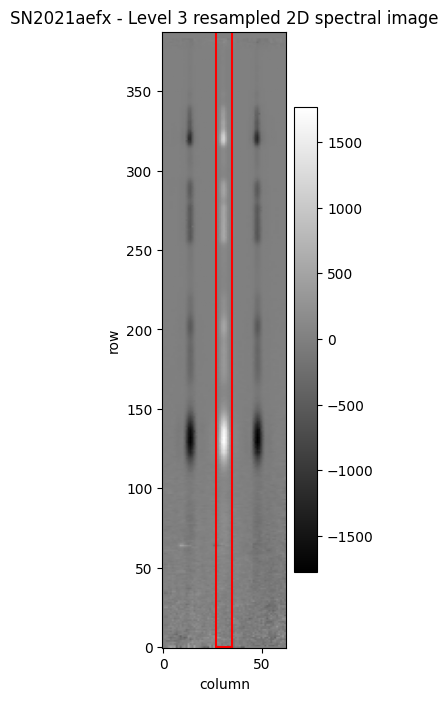

In [8]:
xstart = x1dref_default['apertures'][0]['xstart']
xstop = x1dref_default['apertures'][0]['xstop']
ap_height = np.shape(l3_s2d.data)[0]
ap_width = xstop - xstart + 1
x1d_rect = Rectangle(xy=(xstart, 0), width=ap_width, height=ap_height, angle=0., edgecolor='red',
                     facecolor='None', ls='-', lw=1.5)

fig, ax = plt.subplots(figsize=[2, 8])
im2d = ax.imshow(l3_s2d.data, origin='lower', aspect='auto', cmap='gist_gray')
ax.add_patch(x1d_rect)
ax.set_xlabel('column')
ax.set_ylabel('row')
ax.set_title('SN2021aefx - Level 3 resampled 2D spectral image')
fig.colorbar(im2d)
fig.show()

## Example 1: Changing the extraction width <a id='ex1'></a>

In this example, we demonstrate how to change the extraction width from the default. Instead of 8 pixels, we'll extract 12, keeping the aperture centred on the trace. 

We will modify the values in the json files in python in this notebook, but the file can also simply be edited in a text editor. 

In [9]:
xstart2 = xstart - 2
xstop2 = xstop + 2
print('New xstart, xstop values = {0},{1}'.format(xstart2, xstop2))

with open(json_ref_default) as json_ref:
    x1dref_default = json.load(json_ref)
    x1dref_ex1 = x1dref_default.copy()
    x1dref_ex1['apertures'][0]['xstart'] = xstart2
    x1dref_ex1['apertures'][0]['xstop'] = xstop2

with open('x1d_reffile_example1.json', 'w') as jsrefout:
    json.dump(x1dref_ex1, jsrefout, indent=4)

New xstart, xstop values = 25,36


2025-05-15 19:22:42,199 - stpipe - WARNING - /tmp/ipykernel_2374/1574329999.py:18: UserWarning: Adding colorbar to a different Figure <Figure size 200x800 with 2 Axes> than <Figure size 200x800 with 2 Axes> which fig.colorbar is called on.
  fig.colorbar(im2d)



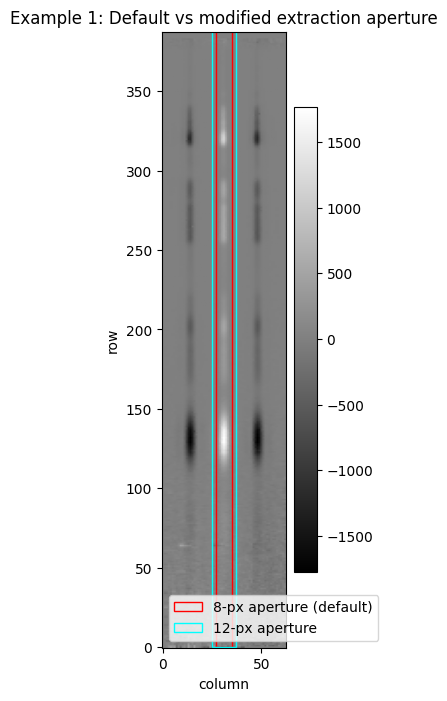

In [10]:
ap_width2 = xstop2 - xstart2 + 1
x1d_rect1 = Rectangle(xy=(xstart, 0), width=ap_width, height=ap_height, angle=0., edgecolor='red',
                      facecolor='None', ls='-', lw=1, label='8-px aperture (default)')

x1d_rect2 = Rectangle(xy=(xstart2, 0), width=ap_width2, height=ap_height, angle=0., edgecolor='cyan',
                      facecolor='None', ls='-', lw=1, label='12-px aperture')

fig4, ax4 = plt.subplots(figsize=[2, 8])
im2d = ax4.imshow(l3_s2d.data, origin='lower', aspect='auto', cmap='gist_gray')
# ax4.add_collection(aps_collection)
ax4.add_patch(x1d_rect1)
ax4.add_patch(x1d_rect2)

ax4.set_xlabel('column')
ax4.set_ylabel('row')
ax4.set_title('Example 1: Default vs modified extraction aperture')
ax4.legend(loc=3)
fig.colorbar(im2d)
fig.show()

Next we run the spectral extraction step, using this modified reference file. Note: when a step is run individually the file name suffix is different from when we run the Spec3Pipeline in its entirety. The extracted spectrum will now have ``extract1dstep.fits`` in the filename. The custom parameters we pass to the step call:

* ``output_file``: we provide a custom output filename for this example (including an output filename renders the ``save_results`` parameter obsolete)
* ``override_extract1d``: here we provide the name of the custom reference file we created above

We will plot the output against the default extracted product. We expect the spectra to be almost identical; differences can be apparent at the longer wavelengths as our path loss correction is less well calibrated in this low SNR region. 

In [11]:
sp3_ex1 = Extract1dStep.call(l3_s2d, output_dir='data/', 
                             output_file='lrs_slit_extract_example1', override_extract1d='x1d_reffile_example1.json')

2025-05-15 19:22:42,404 - stpipe.Extract1dStep - INFO - Extract1dStep instance created.


2025-05-15 19:22:42,503 - stpipe.Extract1dStep - INFO - Step Extract1dStep running with args (<SlitModel(388, 63) from jw02072-o001_t010_miri_p750l_s2d_1089.fits>,).


2025-05-15 19:22:42,507 - stpipe.Extract1dStep - INFO - Step Extract1dStep parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: /home/runner/work/jdat_notebooks/jdat_notebooks/notebooks/MIRI/MIRI_LRS_spectral_extraction/lrs_slit_extract_example1
  output_dir: data/
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: False
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  subtract_background: None
  apply_apcorr: True
  extraction_type: box
  use_source_posn: None
  position_offset: 0.0
  model_nod_pair: True
  optimize_psf_location: True
  smoothing_length: None
  bkg_fit: None
  bkg_order: None
  log_increment: 50
  save_profile: False
  save_scene_model: False
  save_residual_image: False
  center_xy: None
  ifu_autocen: False
  bkg_sigma_clip: 3.0
  ifu_rfcorr: True
  ifu_set_srctype: None
  ifu_rscale: None
  ifu_covar_scale: 1.0
  soss_atoca: True
  soss_threshold: 0.01
  soss_n_os: 2
  soss_wave_grid_in: None
 

2025-05-15 19:22:42,546 - stpipe.Extract1dStep - INFO - Using EXTRACT1D reference file /home/runner/work/jdat_notebooks/jdat_notebooks/notebooks/MIRI/MIRI_LRS_spectral_extraction/x1d_reffile_example1.json


2025-05-15 19:22:42,586 - stpipe.Extract1dStep - INFO - Using APCORR file /home/runner/crds_cache/references/jwst/miri/jwst_miri_apcorr_0007.fits


2025-05-15 19:22:42,625 - CRDS - ERROR -  Error determining best reference for 'psf'  =   Unknown reference type 'psf'


2025-05-15 19:22:42,660 - stpipe.Extract1dStep - WARNING - spectral_order is None; using 1


2025-05-15 19:22:42,661 - stpipe.Extract1dStep - INFO - Processing spectral order 1


2025-05-15 19:22:42,669 - stpipe.Extract1dStep - INFO - Aperture start/stop: 25.00 -> 36.00 (inclusive)


2025-05-15 19:22:42,671 - stpipe.Extract1dStep - INFO - Creating aperture correction.


2025-05-15 19:22:42,944 - stpipe.Extract1dStep - INFO - Results used CRDS context: jwst_1089.pmap


2025-05-15 19:22:43,016 - stpipe.Extract1dStep - INFO - Saved model in data/lrs_slit_extract_example1_extract1dstep.fits


2025-05-15 19:22:43,017 - stpipe.Extract1dStep - INFO - Step Extract1dStep done


2025-05-15 19:22:43,018 - stpipe - INFO - Results used jwst version: 1.18.0


In [12]:
print(sp3_ex1)

<MultiSpecModel from lrs_slit_extract_example1_extract1dstep.fits>


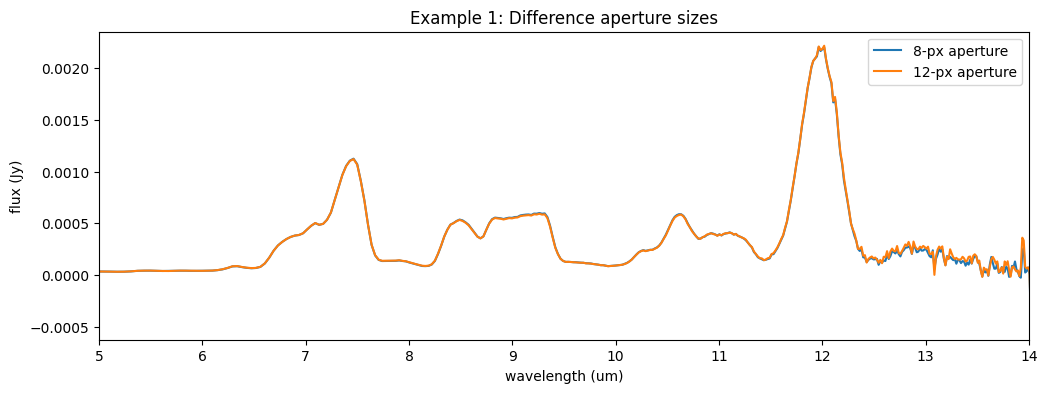

In [13]:
fig5, ax5 = plt.subplots(figsize=[12, 4])
ax5.plot(l3_spec.spec[0].spec_table['WAVELENGTH'], l3_spec.spec[0].spec_table['FLUX'], label='8-px aperture')
ax5.plot(sp3_ex1.spec[0].spec_table['WAVELENGTH'], sp3_ex1.spec[0].spec_table['FLUX'], label='12-px aperture')
ax5.set_xlabel('wavelength (um)')
ax5.set_ylabel('flux (Jy)')
ax5.set_title('Example 1: Difference aperture sizes')
ax5.set_xlim(5., 14.)
ax5.legend()
fig5.show()

## Example 2: Changing aperture location<a id='ex2'></a>

In this example we will demonstrate spectral extraction at a different location in the slit. A good use case for this is to extract a spectrum from one of the nodded exposures, prior to combination of the nods in the Spec3Pipeline. We will take the ``s2d`` output from the Spec2Pipeline, and extract the spectrum. In the nod 1 exposure we see the spectrum peak is located in column 13 (0-indexed), and we extract a default 8-px fixed-width aperture. 

In [14]:
l2_s2d_file = 'data/jw02072001001_06101_00001_mirimage_s2d.fits'
l2_s2d = datamodels.open(l2_s2d_file)

In [15]:
xstart3 = 9
xstop3 = 17

with open(json_ref_default) as json_ref:
    x1dref_default = json.load(json_ref)
    x1dref_ex2 = x1dref_default.copy()
    x1dref_ex2['apertures'][0]['xstart'] = xstart3
    x1dref_ex2['apertures'][0]['xstop'] = xstop3

with open('x1d_reffile_example2.json', 'w') as jsrefout:
    json.dump(x1dref_ex2, jsrefout, indent=4)

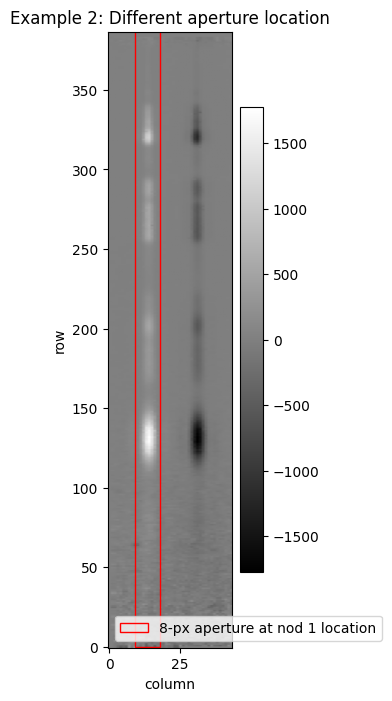

In [16]:
ap_width3 = xstop3 - xstart3 + 1
x1d_rect3 = Rectangle(xy=(xstart3, 0), width=ap_width3, height=ap_height, angle=0., edgecolor='red',
                      facecolor='None', ls='-', lw=1, label='8-px aperture at nod 1 location')

fig6, ax6 = plt.subplots(figsize=[2, 8])
im2d = ax6.imshow(l2_s2d.data, origin='lower', aspect='auto', cmap='gist_gray')
ax6.add_patch(x1d_rect3)
ax6.set_xlabel('column')
ax6.set_ylabel('row')
ax6.set_title('Example 2: Different aperture location')
ax6.legend(loc=3)
fig6.colorbar(im2d)
fig6.show()

In [17]:
sp2_ex2 = Extract1dStep.call(l2_s2d_file, output_dir='data/', output_file='lrs_slit_extract_example2',
                             override_extract1d='x1d_reffile_example2.json')

2025-05-15 19:22:43,489 - stpipe.Extract1dStep - INFO - Extract1dStep instance created.


2025-05-15 19:22:43,596 - stpipe.Extract1dStep - INFO - Step Extract1dStep running with args ('data/jw02072001001_06101_00001_mirimage_s2d.fits',).


2025-05-15 19:22:43,600 - stpipe.Extract1dStep - INFO - Step Extract1dStep parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: /home/runner/work/jdat_notebooks/jdat_notebooks/notebooks/MIRI/MIRI_LRS_spectral_extraction/lrs_slit_extract_example2
  output_dir: data/
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: False
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  subtract_background: None
  apply_apcorr: True
  extraction_type: box
  use_source_posn: None
  position_offset: 0.0
  model_nod_pair: True
  optimize_psf_location: True
  smoothing_length: None
  bkg_fit: None
  bkg_order: None
  log_increment: 50
  save_profile: False
  save_scene_model: False
  save_residual_image: False
  center_xy: None
  ifu_autocen: False
  bkg_sigma_clip: 3.0
  ifu_rfcorr: True
  ifu_set_srctype: None
  ifu_rscale: None
  ifu_covar_scale: 1.0
  soss_atoca: True
  soss_threshold: 0.01
  soss_n_os: 2
  soss_wave_grid_in: None
 

2025-05-15 19:22:43,664 - stpipe.Extract1dStep - INFO - Using EXTRACT1D reference file /home/runner/work/jdat_notebooks/jdat_notebooks/notebooks/MIRI/MIRI_LRS_spectral_extraction/x1d_reffile_example2.json


2025-05-15 19:22:43,705 - stpipe.Extract1dStep - INFO - Using APCORR file /home/runner/crds_cache/references/jwst/miri/jwst_miri_apcorr_0007.fits


2025-05-15 19:22:43,744 - CRDS - ERROR -  Error determining best reference for 'psf'  =   Unknown reference type 'psf'


2025-05-15 19:22:43,774 - stpipe.Extract1dStep - WARNING - spectral_order is None; using 1


2025-05-15 19:22:43,774 - stpipe.Extract1dStep - INFO - Processing spectral order 1


2025-05-15 19:22:43,781 - stpipe.Extract1dStep - INFO - Aperture start/stop: 9.00 -> 17.00 (inclusive)


2025-05-15 19:22:43,783 - stpipe.Extract1dStep - INFO - Creating aperture correction.


2025-05-15 19:22:44,050 - stpipe.Extract1dStep - INFO - Results used CRDS context: jwst_1089.pmap


2025-05-15 19:22:44,120 - stpipe.Extract1dStep - INFO - Saved model in data/lrs_slit_extract_example2_extract1dstep.fits


2025-05-15 19:22:44,121 - stpipe.Extract1dStep - INFO - Step Extract1dStep done


2025-05-15 19:22:44,121 - stpipe - INFO - Results used jwst version: 1.18.0


Let's again plot the output against the default extracted product. We expect this 1-nod spectrum to be noisier but not significantly different from the combined product. The spectrum may have more bad pixels that manifest as spikes or dips in the spectrum. 

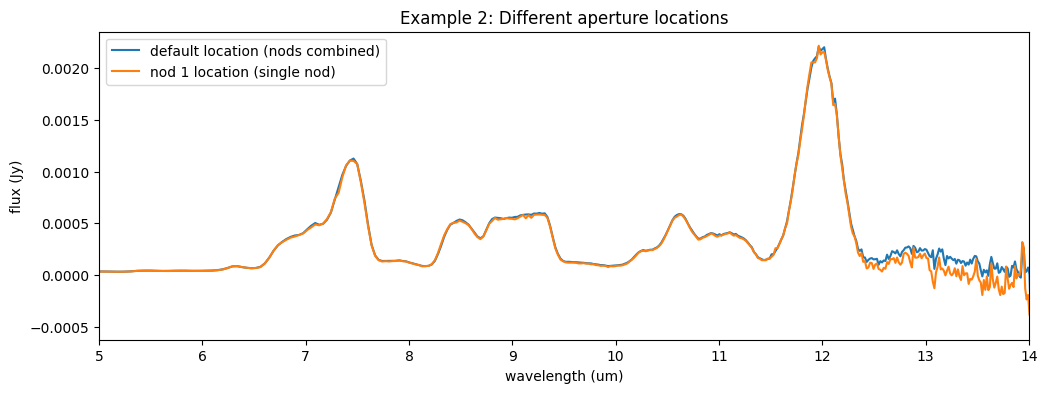

In [18]:
fig7, ax7 = plt.subplots(figsize=[12, 4])
ax7.plot(l3_spec.spec[0].spec_table['WAVELENGTH'], l3_spec.spec[0].spec_table['FLUX'], label='default location (nods combined)')
ax7.plot(sp2_ex2.spec[0].spec_table['WAVELENGTH'], sp2_ex2.spec[0].spec_table['FLUX'], label='nod 1 location (single nod)')
ax7.set_xlabel('wavelength (um)')
ax7.set_ylabel('flux (Jy)')
ax7.set_title('Example 2: Different aperture locations')
ax7.set_xlim(5., 14.)
ax7.legend()
fig7.show()

## Example 3: Extraction with background subtraction<a id='ex3'></a>

For LRS slit observations, the default background subtraction strategy is performed in the ``background`` step in the Spec2Pipeline; the 2 nodded exposures are mutually subtracted, resulting in each returning a 2D spectral image with a positive and a negative trace, and the background subtracted. 

For non-standard cases or slitless LRS data it is however possible to subtract a background as part of the spectral extraction in ``extract_1d``. In the ``extract_1d`` reference file we can pass specific parameters for the background:
* bkg_coeff (list or list of floats): the regions to be used as background. **This is the main parameter required for background subtraction**
* bkg_fit (string): the type or method of the background computation. (e.g. None, 'poly', 'mean' or 'median')
* bkg_order (int): the order of polynomial to fit to background regions. if bkg_fit is not set to 'poly', this parameter will be ignored. 
* smoothing_length (odd int; optional): the width of the boxcar filter that will be used to smooth the background signal in the dispersion direction. This can provide a better quality in case of noisy data. 

The 'poly' option for the ``bkg_fit`` parameter will take the value of all pixels in the background region on a given row, and fit a polynomial of order ``bkg_order`` to them. This option can be useful in cases where a gradient is present in the background. 

The data we're using here already has the background subtracted so we expect the impact of this to be minimal, but we provide a demonstration using the nod 1, level 2b spectral image. In this example we will calculate the background from 2 4-column windows, setting the ``bkg_fit`` to 'median'. 



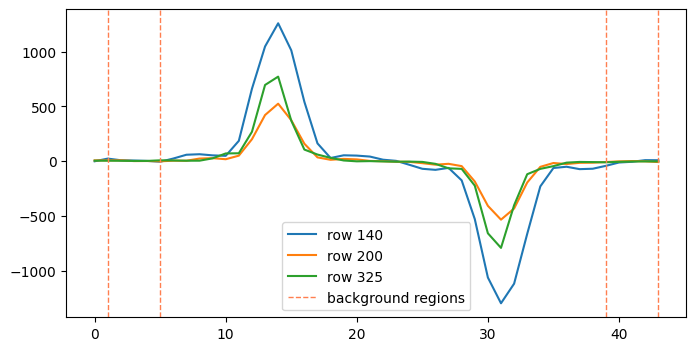

In [19]:
rows = [140, 200, 325]
fig8, ax8 = plt.subplots(figsize=[8, 4])
ncols = np.shape(l2_s2d.data)[1]
pltx = np.arange(ncols)
for rr in rows:
    label = 'row {}'.format(rr)
    ax8.plot(pltx, l2_s2d.data[rr, :], label=label)
ax8.axvline(x=1, ymin=0, ymax=1, ls='--', lw=1., color='coral', label='background regions')
ax8.axvline(x=5, ymin=0, ymax=1, ls='--', lw=1., color='coral')
ax8.axvline(x=39, ymin=0, ymax=1, ls='--', lw=1., color='coral')
ax8.axvline(x=43, ymin=0, ymax=1, ls='--', lw=1., color='coral')
ax8.legend()
fig8.show()

In [20]:
with open(json_ref_default) as json_ref:
    x1dref_default = json.load(json_ref)
    x1dref_ex3 = x1dref_default.copy()
    x1dref_ex3['apertures'][0]['xstart'] = xstart3
    x1dref_ex3['apertures'][0]['xstop'] = xstop3
    x1dref_ex3['apertures'][0]['bkg_coeff'] = [[0.5], [4.5], [38.5], [43.5]]
    x1dref_ex3['apertures'][0]['bkg_fit'] = 'median'

with open('x1d_reffile_example3.json', 'w') as jsrefout:
    json.dump(x1dref_ex3, jsrefout, indent=4)

In [21]:
sp2_ex3 = Extract1dStep.call(l2_s2d_file, output_dir='data/', output_file='lrs_slit_extract_example3',
                             override_extract1d='x1d_reffile_example3.json')

2025-05-15 19:22:44,450 - stpipe.Extract1dStep - INFO - Extract1dStep instance created.


2025-05-15 19:22:44,556 - stpipe.Extract1dStep - INFO - Step Extract1dStep running with args ('data/jw02072001001_06101_00001_mirimage_s2d.fits',).


2025-05-15 19:22:44,559 - stpipe.Extract1dStep - INFO - Step Extract1dStep parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: /home/runner/work/jdat_notebooks/jdat_notebooks/notebooks/MIRI/MIRI_LRS_spectral_extraction/lrs_slit_extract_example3
  output_dir: data/
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: False
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  subtract_background: None
  apply_apcorr: True
  extraction_type: box
  use_source_posn: None
  position_offset: 0.0
  model_nod_pair: True
  optimize_psf_location: True
  smoothing_length: None
  bkg_fit: None
  bkg_order: None
  log_increment: 50
  save_profile: False
  save_scene_model: False
  save_residual_image: False
  center_xy: None
  ifu_autocen: False
  bkg_sigma_clip: 3.0
  ifu_rfcorr: True
  ifu_set_srctype: None
  ifu_rscale: None
  ifu_covar_scale: 1.0
  soss_atoca: True
  soss_threshold: 0.01
  soss_n_os: 2
  soss_wave_grid_in: None
 

2025-05-15 19:22:44,623 - stpipe.Extract1dStep - INFO - Using EXTRACT1D reference file /home/runner/work/jdat_notebooks/jdat_notebooks/notebooks/MIRI/MIRI_LRS_spectral_extraction/x1d_reffile_example3.json


2025-05-15 19:22:44,664 - stpipe.Extract1dStep - INFO - Using APCORR file /home/runner/crds_cache/references/jwst/miri/jwst_miri_apcorr_0007.fits


2025-05-15 19:22:44,704 - CRDS - ERROR -  Error determining best reference for 'psf'  =   Unknown reference type 'psf'


2025-05-15 19:22:44,734 - stpipe.Extract1dStep - WARNING - spectral_order is None; using 1


2025-05-15 19:22:44,734 - stpipe.Extract1dStep - INFO - Processing spectral order 1


2025-05-15 19:22:44,741 - stpipe.Extract1dStep - INFO - Aperture start/stop: 9.00 -> 17.00 (inclusive)


2025-05-15 19:22:44,742 - stpipe.Extract1dStep - INFO - Mean aperture start/stop from bkg_coeff: 1.00 -> 4.00 (inclusive)


2025-05-15 19:22:44,743 - stpipe.Extract1dStep - INFO - Mean aperture start/stop from bkg_coeff: 39.00 -> 43.00 (inclusive)


2025-05-15 19:22:44,745 - stpipe.Extract1dStep - INFO - Creating aperture correction.


2025-05-15 19:22:45,009 - stpipe.Extract1dStep - INFO - Results used CRDS context: jwst_1089.pmap


2025-05-15 19:22:45,078 - stpipe.Extract1dStep - INFO - Saved model in data/lrs_slit_extract_example3_extract1dstep.fits


2025-05-15 19:22:45,079 - stpipe.Extract1dStep - INFO - Step Extract1dStep done


2025-05-15 19:22:45,080 - stpipe - INFO - Results used jwst version: 1.18.0


When the ``extract_1d`` step performs a background subtraction, the background spectrum is part of the output product, so you can check what was subtracted. In the plot below we can see that, as expected, the background for this particular exposure is near-zero (apart from the noisy long-wavelength end), as the subtraction was already performed. 

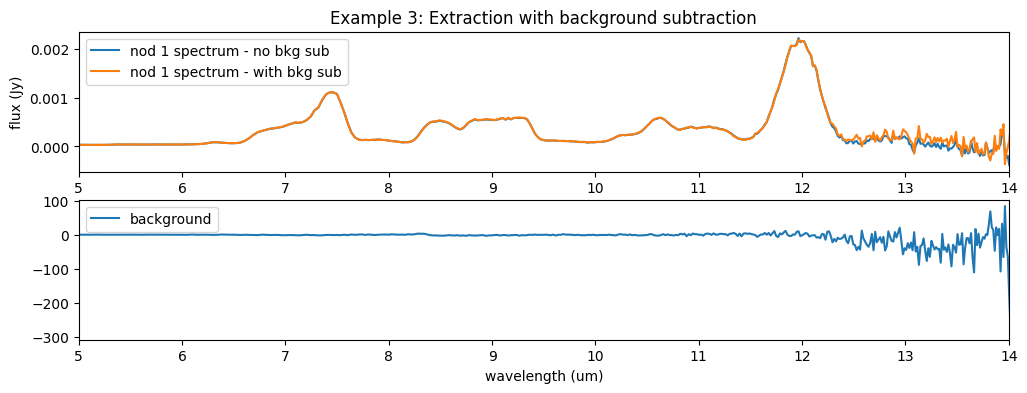

In [22]:
fig9, ax9 = plt.subplots(nrows=2, ncols=1, figsize=[12, 4])
# ax9.plot(l3_spec.spec[0].spec_table['WAVELENGTH'], l3_spec.spec[0].spec_table['FLUX'], label='default location (nods combined)')
ax9[0].plot(sp2_ex2.spec[0].spec_table['WAVELENGTH'], sp2_ex2.spec[0].spec_table['FLUX'], label='nod 1 spectrum - no bkg sub')
ax9[0].plot(sp2_ex3.spec[0].spec_table['WAVELENGTH'], sp2_ex3.spec[0].spec_table['FLUX'], label='nod 1 spectrum - with bkg sub')
ax9[1].plot(sp2_ex3.spec[0].spec_table['WAVELENGTH'], sp2_ex3.spec[0].spec_table['BACKGROUND'], label='background')
ax9[1].set_xlabel('wavelength (um)')
ax9[0].set_ylabel('flux (Jy)')
ax9[0].set_title('Example 3: Extraction with background subtraction')
ax9[0].set_xlim(5., 14.)
ax9[1].set_xlim(5., 14.)
ax9[0].legend()
ax9[1].legend()
fig9.show()

## Example 4: Tapered column extraction<a id='ex4'></a>

In this example we will use the JWST calibration pipeline to perform a spectral extraction in a tapered column aperture. The way to specify this in the extraction reference file is to use the ``src_soeff`` parameter instead of the simpler ``xstart``, ``xstop`` settings. The ``src_coeff`` parameter can take polynomial coefficients rather than fixed pixel values. In this example, we will define a tapered column aperture corresponding to 3 * the FWHM of the spatial profile. 

Polynomial definitions for the extraction aperture can be specified as a function of pixels or wavelength, which is defined in the ``independent_var`` parameter. 

We will use pre-measured FWHM values as a function of **wavelength** to fit a straight line to the FWHM($\lambda$) profile, and set the extraction parameters according to this fit. The FWHM can of course also be measured directly from the data as well. 

In [23]:
def calc_xap_fit():
    # these are values measured from commissioning data. FWHM is in arcsec.
    lam = [5.0, 7.5, 10.0, 12.0]
    fwhm = [0.29, 0.3, 0.36, 0.42]

    # convert from arcsec to pixel using MIRI pixel scaling of 0.11 arcsec/px
    fwhm_px = fwhm / (0.11*u.arcsec/u.pixel)

    # we want to extract 3 * fwhm, which means 1.5 * fwhm on either side of the trace
    xap_pix = 1.5 * fwhm_px

    # now we want to fit a line to these points
    line_init = models.Linear1D()
    fit = fitting.LinearLSQFitter()

    fitted_line = fit(line_init, lam, xap_pix.value)
    print(fitted_line)

    fig, ax = plt.subplots(figsize=[8, 4])
    xplt = np.linspace(4.0, 14., num=50)
    ax.plot(lam, xap_pix.value, 'rx', label='1.5 * FWHM(px)')
    ax.plot(xplt, fitted_line(xplt), 'b-', label='best-fit line')
    ax.set_xlabel('wavelength')
    ax.set_ylabel('px')
    ax.legend()

    return fitted_line

Model: Linear1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
          slope            intercept    
    ------------------ -----------------
    0.2579519802996102 2.445618715370405
Parameter('slope', value=0.2579519802996102) Parameter('intercept', value=2.445618715370405)


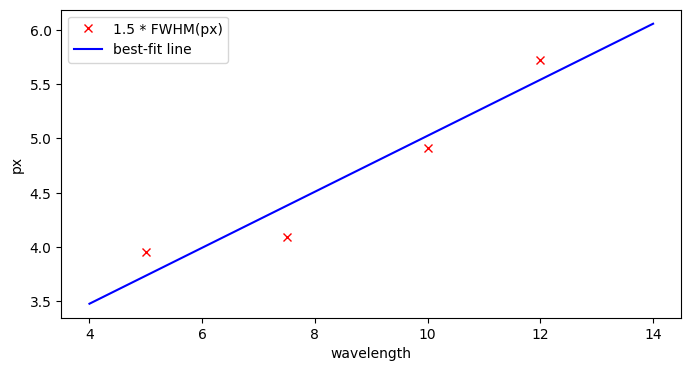

In [24]:
poly_pos = calc_xap_fit()
print(poly_pos.slope, poly_pos.intercept)

The above polynomial defines the relationship between wavelength and the number of pixels to extract. To ensure that the extractio location is centred on the location of the spectrum, we add to the intercept value the central location of the trace, which is at column 30.5. 

In the next cell, we provide these parameters to the ``src_coeff`` parameter in the extraction reference file. **Note: The ``src_coeff`` parameter takes precedence over the ``xstart`` and ``xstop`` parameters if all 3 are present; for clarity we remove the latter from our reference file.**

In [25]:
trace_cen = 30.5

with open(json_ref_default) as json_ref:
    x1dref_default = json.load(json_ref)
    x1dref_ex4 = x1dref_default.copy()
    x1dref_ex4['apertures'][0]['xstart'] = None
    x1dref_ex4['apertures'][0]['xstop'] = None
    x1dref_ex4['apertures'][0]['independent_var'] = 'wavelength'
    x1dref_ex4['apertures'][0]['src_coeff'] = [[-1*poly_pos.intercept.value + trace_cen, -1*poly_pos.slope.value], [poly_pos.intercept.value + trace_cen, poly_pos.slope.value]]

with open('x1d_reffile_example4.json', 'w') as jsrefout:
    json.dump(x1dref_ex4, jsrefout, indent=4)

In [26]:
sp3_ex4 = Extract1dStep.call(l3_s2d, output_dir='data/', 
                             output_file='lrs_slit_extract_example4', override_extract1d='x1d_reffile_example4.json')

2025-05-15 19:22:45,442 - stpipe.Extract1dStep - INFO - Extract1dStep instance created.


2025-05-15 19:22:45,550 - stpipe.Extract1dStep - INFO - Step Extract1dStep running with args (<SlitModel(388, 63) from jw02072-o001_t010_miri_p750l_s2d_1089.fits>,).


2025-05-15 19:22:45,554 - stpipe.Extract1dStep - INFO - Step Extract1dStep parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: /home/runner/work/jdat_notebooks/jdat_notebooks/notebooks/MIRI/MIRI_LRS_spectral_extraction/lrs_slit_extract_example4
  output_dir: data/
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: False
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  subtract_background: None
  apply_apcorr: True
  extraction_type: box
  use_source_posn: None
  position_offset: 0.0
  model_nod_pair: True
  optimize_psf_location: True
  smoothing_length: None
  bkg_fit: None
  bkg_order: None
  log_increment: 50
  save_profile: False
  save_scene_model: False
  save_residual_image: False
  center_xy: None
  ifu_autocen: False
  bkg_sigma_clip: 3.0
  ifu_rfcorr: True
  ifu_set_srctype: None
  ifu_rscale: None
  ifu_covar_scale: 1.0
  soss_atoca: True
  soss_threshold: 0.01
  soss_n_os: 2
  soss_wave_grid_in: None
 

2025-05-15 19:22:45,594 - stpipe.Extract1dStep - INFO - Using EXTRACT1D reference file /home/runner/work/jdat_notebooks/jdat_notebooks/notebooks/MIRI/MIRI_LRS_spectral_extraction/x1d_reffile_example4.json


2025-05-15 19:22:45,634 - stpipe.Extract1dStep - INFO - Using APCORR file /home/runner/crds_cache/references/jwst/miri/jwst_miri_apcorr_0007.fits


2025-05-15 19:22:45,673 - CRDS - ERROR -  Error determining best reference for 'psf'  =   Unknown reference type 'psf'


2025-05-15 19:22:45,704 - stpipe.Extract1dStep - WARNING - spectral_order is None; using 1


2025-05-15 19:22:45,704 - stpipe.Extract1dStep - INFO - Processing spectral order 1


2025-05-15 19:22:45,713 - stpipe.Extract1dStep - INFO - Mean aperture start/stop from src_coeff: 25.90 -> 35.10 (inclusive)


2025-05-15 19:22:45,715 - stpipe.Extract1dStep - INFO - Creating aperture correction.


2025-05-15 19:22:45,988 - stpipe.Extract1dStep - INFO - Results used CRDS context: jwst_1089.pmap


2025-05-15 19:22:46,056 - stpipe.Extract1dStep - INFO - Saved model in data/lrs_slit_extract_example4_extract1dstep.fits


2025-05-15 19:22:46,057 - stpipe.Extract1dStep - INFO - Step Extract1dStep done


2025-05-15 19:22:46,057 - stpipe - INFO - Results used jwst version: 1.18.0


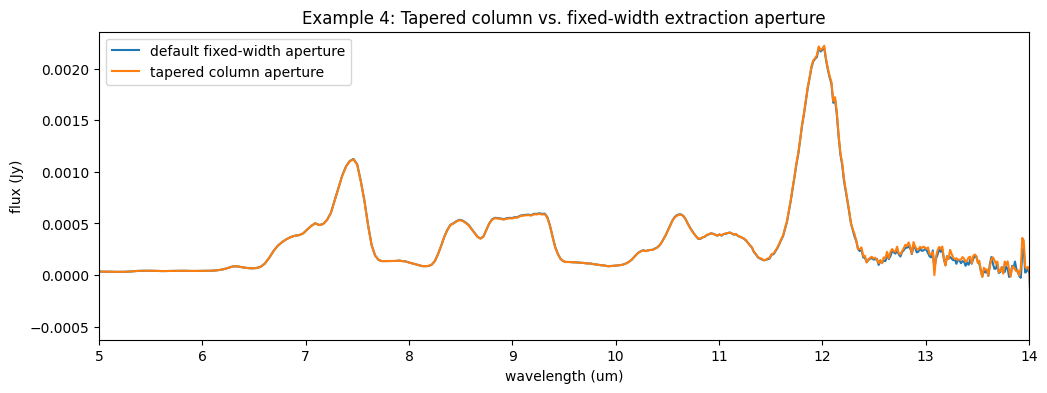

In [27]:
fig10, ax10 = plt.subplots(figsize=[12, 4])
ax10.plot(l3_spec.spec[0].spec_table['WAVELENGTH'], l3_spec.spec[0].spec_table['FLUX'], label='default fixed-width aperture')
ax10.plot(sp3_ex4.spec[0].spec_table['WAVELENGTH'], sp3_ex4.spec[0].spec_table['FLUX'], label='tapered column aperture')
ax10.set_xlabel('wavelength (um)')
ax10.set_ylabel('flux (Jy)')
ax10.set_title('Example 4: Tapered column vs. fixed-width extraction aperture')
ax10.set_xlim(5., 14.)
ax10.legend()
fig10.show()

The output spectrum also contains a reference to the number of pixels used for the extraction as a function of wavelength. Let's visualize that too. 


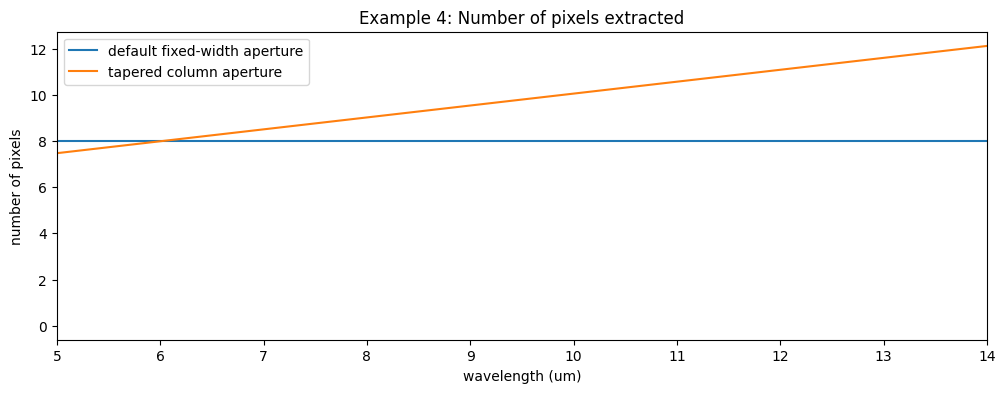

In [28]:
fig11, ax11 = plt.subplots(figsize=[12, 4])
ax11.plot(l3_spec.spec[0].spec_table['WAVELENGTH'], l3_spec.spec[0].spec_table['NPIXELS'], label='default fixed-width aperture')
ax11.plot(sp3_ex4.spec[0].spec_table['WAVELENGTH'], sp3_ex4.spec[0].spec_table['NPIXELS'], label='tapered column aperture')
ax11.set_xlabel('wavelength (um)')
ax11.set_ylabel('number of pixels')
ax11.set_title('Example 4: Number of pixels extracted')
ax11.set_xlim(5., 14.)
ax11.legend()
fig11.show()

## Summary

We hope this notebook was useful in helping you understand the capabilities of the JWST calibration for spectral extraction. The above examples are not an exhaustive list of all the possibilities: different methods of source and background extraction can be combined for more complex extraction operations. 

**If you have any questions, comments, or requests for further demos of these capabilities, please contact the [JWST Helpdesk](http://jwsthelp.stsci.edu/).**